# Régime d'oscillations libres par superposition modale (transitoire)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.integrate import odeint
import scipy.fftpack
from scipy import signal
plt.rcParams['figure.figsize'] = [12, 3]
from scipy import optimize
import functools
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Paramètres de la poutre

In [2]:
n_elem=10; # nombre d'éléments --> A MODIFIER
E=203000000000; # module d'Young --> Acier inoxydable
rho=7900; # masse volumique --> Acier inoxydable
e=0.0005; # épaisseur de la lame --> Réglet SAM  781-3
b=0.013; # largeur de la lame --> Réglet SAM  781-3
l=0.270; # longueur de la lame --> Réglet SAM  781-3
ksi_rayleigh=0.0052; # taux d'amortissement (visqueux) de la lame --> A MODIFIER expérimental, oscillation libre
S=e*b; # Section de la poutre
x=np.linspace(0,l,101); # Coordonnées le long de la poutre
m = rho*S*l #masse totale
print("m=",m)

m= 0.0138645


La masse de l'accéléromètres est de 4g, soit 30% de la masse du réglet

## Paramètres d'intégration

In [3]:
deltat=0.02; # pas de temps --> A MODIFIER
duree=7; # plage d'integration --> A MODIFIER
nb_pt=int(duree/deltat); # Discrétisation temporelle
qmax=0.03; # deplacement du point sollicite --> A MODIFIER

## Construction des matrices de masse et de raideur

\begin{equation}
\left[ M \right] =
\frac{\rho S l}{420} \left[ \begin{array}{c c}
156 & 22l & 54 & -13l \\
22l & 4l^2 & 13l & -3l^2 \\
54 & 13l & 156 & -22l \\
-13l & -3l^2 & -22l & 4l^2 
\end{array} \right]
\end{equation}

\begin{equation}
\left[ K \right] =
\frac{EI}{l^3} \left[ \begin{array}{c c}
12 & 6l & -12 & 6l \\
6l & 4l^2 & -6l & 2l^2 \\
-12 & -6l & 12 & -6l \\
6l & 2l^2 & -6l & 4l^2
\end{array} \right]
\end{equation}


In [4]:
# A[ligne,colonne]

In [5]:
Iz = b*e**3/12
l_elem=l/n_elem; # longueur d'un élément

k_elem=E*Iz/(l_elem**3)*np.array([[12,6*l_elem,-12,6*l_elem],[6*l_elem,4*l_elem**2,-6*l_elem,2*l_elem**2],[-12,-6*l_elem,12,-6*l_elem],[6*l_elem,2*l_elem**2,-6*l_elem,4*l_elem**2]]);
m_elem=rho*S*l_elem/420*np.array([[156,22*l_elem,54,-13*l_elem],[22*l_elem,4*l_elem**2,13*l_elem,-3*l_elem**2],[54,13*l_elem,156,-22*l_elem],[-13*l_elem,-3*l_elem**2,-22*l_elem,4*l_elem**2]]);


k_ass0=np.zeros(((n_elem+1)*2,(n_elem+1)*2));
m_ass0=np.zeros(((n_elem+1)*2,(n_elem+1)*2));

#print("k_ass0 =",k_ass0);
#print("m_ass0 =",m_ass0);

for j in range(n_elem):
    k_ass0[j*2:j*2+4,j*2:j*2+4]=k_ass0[j*2:j*2+4,j*2:j*2+4]+k_elem;
    m_ass0[j*2:j*2+4,j*2:j*2+4]=m_ass0[j*2:j*2+4,j*2:j*2+4]+m_elem;

k_ass=k_ass0[2:2*(n_elem+1),2:2*(n_elem+1)];
m_ass=m_ass0[2:2*(n_elem+1),2:2*(n_elem+1)];

m_ass[len(m_ass[0,:])-2,len(m_ass[:,0])-2] += 0.004 #accéléromètre

print("k_ass =\n",k_ass);
print("m_ass =\n",m_ass);

k_ass =
 [[ 3.35187725e+04  0.00000000e+00 -1.67593863e+04  2.26251715e+02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  8.14506173e+00 -2.26251715e+02  2.03626543e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.67593863e+04 -2.26251715e+02  3.35187725e+04  0.00000000e+00
  -1.67593863e+04  2.26251715e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00

## Pulsations et modes analytiques

$k \in \mathbb{N}^{*}$,
\begin{equation}
\omega_{k} = ((2k-1) \frac{\pi}{2})^2  \sqrt{\frac{EI_z}{ml^3}}
\end{equation}

\begin{equation}
\phi_{k}(x)= cf \ page \ 45
\end{equation}

In [6]:
omega_ana=np.zeros((n_elem,1));
Phi_ana=np.zeros((n_elem,len(x)));
for k in range(n_elem):
    if k==0:
        omega_ana[k] = (1.87**2)*np.sqrt(E*Iz/(m*l**3))
    else:
        omega_ana[k]=(((2*(k+1)-1)*np.pi/2)**2)*np.sqrt(E*Iz/(m*l**3));
    for j in range(len(x)):
        A = (((omega_ana[k]**2)*rho*S/E/Iz)**(1/4))*x[j]
        B = (((omega_ana[k]**2)*rho*S/E/Iz)**(1/4))*l
        Phi_ana[k,j]=np.cos(A)-np.cosh(A)+(np.sin(B)-np.sinh(B))/(np.cos(B)+np.cosh(B))*(np.sin(A)-np.sinh(A));
        
print("omega_ana = ", omega_ana)



#print("Phi_ana = ", Phi_ana)
print("freq = ",omega_ana/2/np.pi)

omega_ana =  [[  35.09696312]
 [ 222.87871224]
 [ 619.10753401]
 [1213.45076666]
 [2005.90841019]
 [2996.48046461]
 [4185.16692991]
 [5571.96780609]
 [7156.88309315]
 [8939.9127911 ]]
freq =  [[   5.58585517]
 [  35.47224876]
 [  98.53402434]
 [ 193.12668771]
 [ 319.25023887]
 [ 476.90467782]
 [ 666.09000456]
 [ 886.80621909]
 [1139.05332141]
 [1422.83131151]]


## Résolution du problème aux valeurs propres

La détermination des pulsations propres et des modes propres consiste à résoudre le problème suivant :

\begin{equation}
det \left( \left[ M \right]^{-1} \left[ K \right] - \omega^{2}_{i} \left[ I \right] \right) = 0
\end{equation}

In [7]:
val_propres, vect_propres = la.eig(np.dot(la.inv(m_ass),k_ass)); # problème aux valeurs propres
omegar=np.sqrt(np.real(val_propres));
print("omegar =",omegar);
o_omegar=np.argsort(omegar); # tri des modes (dans le sens croissant)
print("o_omegar =",o_omegar);
print("omegar[o_omegar] =",omegar[o_omegar]);

#On sépare les vecteurs propres correspondants aux déplacements tranversaux des déplacements angulaires:
#Conditions aux limites
vps_T = np.zeros((1,2*n_elem)) #Transversaux
vps_A = np.zeros((1,2*n_elem)) #Angulaire
#print(vps_T)
for i in range(n_elem):
    vps_T = np.concatenate((vps_T,[vect_propres[i*2,:]]),axis=0)
    vps_A = np.concatenate((vps_A,[vect_propres[i*2+1,:]]),axis=0)

vps=np.concatenate((np.zeros((1,2*n_elem)),vect_propres), axis=0); # ajout des conditions aux limites
#print("vps =",vps);
print("vps[o_omegar] =",np.real(vps[:,o_omegar]));
print("vps_T= ",vps_T)

omegar = [5.00109380e+04 4.65383015e+04 4.10640352e+04 3.51227193e+04
 2.95677397e+04 2.46878775e+04 2.05017058e+04 1.69383773e+04
 1.39242704e+04 1.15369511e+04 8.76295980e+03 6.93998495e+03
 5.32191326e+03 3.93715219e+03 2.77469533e+03 1.82360060e+03
 1.07647496e+03 5.29002083e+02 1.76982503e+02 2.39389100e+01]
o_omegar = [19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
omegar[o_omegar] = [2.39389100e+01 1.76982503e+02 5.29002083e+02 1.07647496e+03
 1.82360060e+03 2.77469533e+03 3.93715219e+03 5.32191326e+03
 6.93998495e+03 8.76295980e+03 1.15369511e+04 1.39242704e+04
 1.69383773e+04 2.05017058e+04 2.46878775e+04 2.95677397e+04
 3.51227193e+04 4.10640352e+04 4.65383015e+04 5.00109380e+04]
vps[o_omegar] = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00

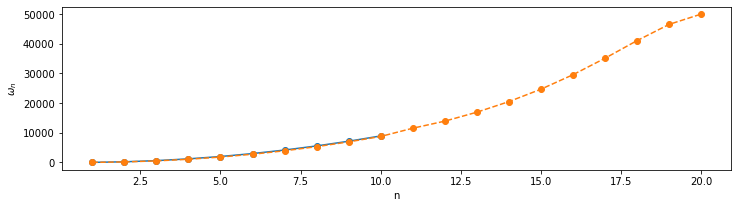

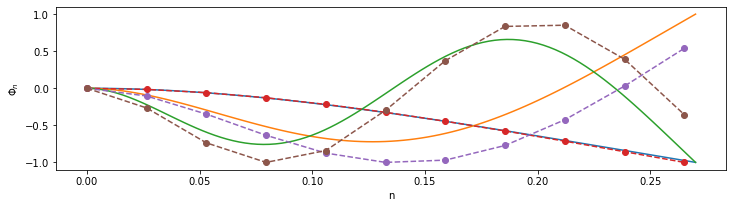

In [8]:
plt.figure();
plt.plot(range(1,n_elem+1),omega_ana,'-o');
plt.plot(range(1,2*n_elem+1),omegar[o_omegar],'--o');
plt.xlabel("n");
plt.ylabel("$\omega_{n}$");
#plt.xlim(0.75,1.25)
#plt.ylim(0,100)
plt.figure();

#for i in range(n_elem):
for i in range(3):    #3 premiers modes
    plt.plot(x,Phi_ana[i,:]/np.max(np.abs(Phi_ana[i,:])),'-');
#print(np.arange(0,2*n_elem-1,1)/(n_elem)*0.265)
#for i in range(2*n_elem):
for i in range(3):
    plt.plot(np.arange(0,n_elem+1,1)/(n_elem)*0.265,-np.real(vps_T[:,o_omegar][:,i])/np.max(np.abs(np.real(vps_T[:,o_omegar][:,i])))*np.sign(np.real(vps_T[:,o_omegar][1,i])),'--o');

plt.xlabel("n");
plt.ylabel("$\Phi_{n}$");


## Application des conditions initiales

Le vecteur $\left\lbrace q \right\rbrace$ s'écrit comme la combinaison linéaire des $N$ vecteurs propres $\left\lbrace x_{i=1..N} \right\rbrace$ :

\begin{equation}
\left\lbrace q \right\rbrace = \Sigma^{N}_{i=1} \eta_{i} \left\lbrace x_{i} \right\rbrace
\end{equation}

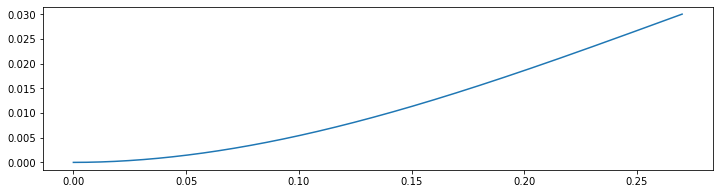

In [9]:
#fonction de la position du réglet, inspiré de l'ex 1 qu 2 TD1 :
def deplInit(x):
    return 3*qmax/(l**3)*(l*(x**2)/2 - (x**3)/6)
    
#déplacement angulaire = dérivée
def deplInitAngl(x):
    return 3*qmax/(l**3)*(l*x - (x**2)/2)

xx = np.linspace(0,l,1000)
plt.plot(xx,deplInit(xx))

In [10]:
qq=np.zeros((2*n_elem,nb_pt));
eta=np.zeros((2*n_elem,nb_pt));
qq[0,0]=0
for i in range(1,2*n_elem):
    if(i%2==0):
        qq[i,0]=deplInit(i*l/2/n_elem) # déformation homogène de la poutre A modifier pour correspondre td1 ex2 qu2, pour les angles dériver la formule en x.
    else:
        qq[i,0]=deplInitAngl(i*l/2/n_elem)
print("shape(qq) = ",np.shape(qq))
print("shape(vps[1:2*n_elem+1]) = ",np.shape(vps[1:2*n_elem+1]))
eta[:,0]=np.dot(np.linalg.inv(vps[1:2*n_elem+1,o_omegar]),qq[:,0]); # détermination des composantes initiales dans la base modale à partir de celles dans la base physique
print(eta[:,0]);
print(np.shape(eta))

shape(qq) =  (20, 350)
shape(vps[1:2*n_elem+1]) =  (20, 20)
[-3.29547133e-01 -6.64592776e-02  1.52306292e-02 -1.29114045e-02
  5.15030135e-03 -4.01752973e-03  1.33432685e-03 -1.03847860e-03
  9.05425451e-05 -1.81191605e-04  8.75756715e-05  6.34905700e-04
  1.04489538e-03  1.73324393e-03 -2.86625785e-03  3.82718137e-03
 -6.58015923e-03 -8.27957727e-03 -2.03487724e-02  2.05940211e-02]
(20, 350)


## Affectation des paramètres et des efforts extérieurs

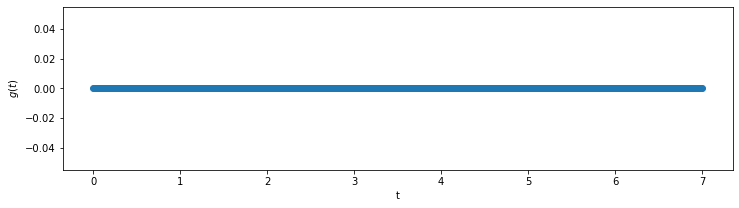

In [11]:
ksi=np.zeros((2*n_elem,1));
omegar_red=np.zeros((2*n_elem,1));
dot_eta_init=np.zeros((2*n_elem,1));
gg=np.zeros((2*n_elem,nb_pt));
t=np.linspace(0,duree,nb_pt);
for i in range(2*n_elem):
    ksi[i]=ksi_rayleigh; # taux d'amortissement
    omegar_red[i]=omegar[o_omegar][i]*np.sqrt(1-ksi[i]**2); # pulsation réduite
    dot_eta_init[i]=0; # vitesses initiales nulles
    for pt in range(nb_pt):
        gg[n_elem-1,pt]=0; # force constante
        #gg[n_elem-1,pt]=1000*t[pt]/duree; # force progressive
        #gg[n_elem-1,pt]=1000*np.sin(2*np.pi*1200*t[pt]); # force sinusoïdale
        #if 0<pt<2: #impulsion
        #    gg[n_elem-1,pt]=1000;
        #else:
        #    gg[n_elem-1,pt]=0;

plt.plot(t,gg[n_elem-1,:],'-o')
plt.xlabel("t");
plt.ylabel("$g(t)$");

## Intégration numérique

Le changement de base permet d'obtenir pour chaque mode i ($1\le i \le n_{modes}$) :

\begin{equation}
\lambda_{i} \eta_{i} + 2 \xi_{i} \omega_{i} \dot{\eta_{i}} + \ddot{\eta_{i}} = \frac{\left\lbrace x_{i} \right\rbrace^{T} \left\lbrace F \right\rbrace}{\mu_{i}} = \frac{\left\lbrace x_{i} \right\rbrace^{T} \left\lbrace g(t) \right\rbrace}{\mu_{i}}
\end{equation}

Soit le mode $i$, la solution de l'équation différentielle associée est donnée par :

\begin{equation}
\begin{array}{l c l}
\eta_{i}(t) & = & e^{-\xi_{i}\omega_{i}t} \left[ cos \left(\omega_{i}\sqrt{1-\xi_{i}^{2}}t \right)+\frac{\xi_{i}}{\sqrt{1-\xi_{i}^{2}}} sin \left(\omega_{i}\sqrt{1-\xi_{i}^{2}}t \right) \right]\eta_{i}(0) + e^{-\xi_{i}\omega_{i}t}\left[ \frac{sin \left(\omega_{i}\sqrt{1-\xi_{i}^{2}}t \right)}{\omega_{i}\sqrt{1-\varepsilon_{i}^{2}}} \right]\dot{\eta_{i}}(0) \\ & & \\ & &
+ \int_{0}^{t} e^{-\xi_{i}\omega_{i}(t-\tau)} \frac{sin \left(\omega_{i}\sqrt{1-\xi_{i}^{2}}(t-\tau) \right)}{\omega_{i}\sqrt{1-\xi_{i}^{2}}} \frac{\left\lbrace x_{i} \right\rbrace^{T} \left\lbrace g(\tau) \right\rbrace }{\mu_{i}}d\tau
\end{array}
\end{equation}

In [12]:
mu=np.zeros((2*n_elem,1));
TT=np.zeros((2*n_elem,nb_pt));

for i in range(n_elem):
    print("i =",i);
    mu_temp=np.dot(m_ass,vps[1:2*n_elem+1,o_omegar][:,i]);
    mu[i]=np.vdot(vps[1:2*n_elem+1,o_omegar][:,i],mu_temp);
    for pt in range(nb_pt):
        #print("pt =",pt);
        delta_tau=deltat;
        tau1=0;
        TT[i,pt]=0;
        for k in range(pt): # intégration numérique liée au second membre par la méthode des trapèzes
            f_tau1=np.exp(-ksi[i]*omegar[o_omegar][i]*(t[pt]-tau1))*np.sin(omegar_red[i]*(t[pt]-tau1))/omegar_red[i]*np.dot(vps[1:2*n_elem+1,o_omegar][:,i],gg[:,k])/mu[i];
            f_tau2=np.exp(-ksi[i]*omegar[o_omegar][i]*(t[pt]-(tau1+delta_tau)))*np.sin(omegar_red[i]*(t[pt]-(tau1+delta_tau)))/omegar_red[i]*np.dot(vps[1:2*n_elem+1,o_omegar][:,i],gg[:,k+1])/mu[i];
            TT[i,pt]=TT[i,pt]+delta_tau*(f_tau1+f_tau2)/2;
            tau1=tau1+delta_tau;
        eta[i,pt]=np.exp(-ksi[i]*omegar[o_omegar][i]*t[pt])*(np.cos(omegar_red[i]*t[pt])+ksi[i]/np.sqrt(1-ksi[i]**2)*np.sin(omegar_red[i]*t[pt]))*eta[i,0]+np.exp(-ksi[i]*omegar[o_omegar][i]*t[pt])/omegar_red[i]*np.sin(omegar_red[i]*t[pt])*dot_eta_init[i]+TT[i,pt];

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9


## Calcul des paramètres généralisés

Retour à la base physique de départ :

\begin{equation}
\left\lbrace q \right\rbrace = \Sigma^{N}_{i=1} \eta_{i} \left\lbrace x_{i} \right\rbrace
\end{equation}

In [13]:
for pt in range(1,nb_pt):
    qq[:,pt]=np.dot(vps[1:2*n_elem+1,o_omegar],eta[:,pt]);
print(np.shape(vps))
print(np.shape(eta))
qf=np.zeros((2*n_elem+1,nb_pt));
qf[0:2*n_elem,:]=qq;

(21, 20)
(20, 350)


0
2
4
(21, 350)


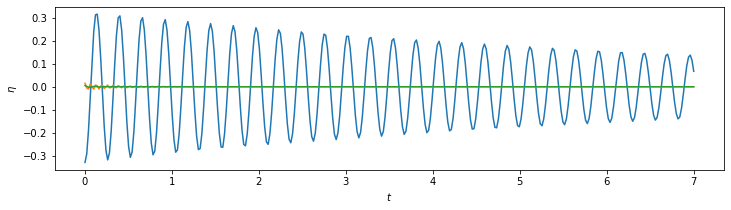

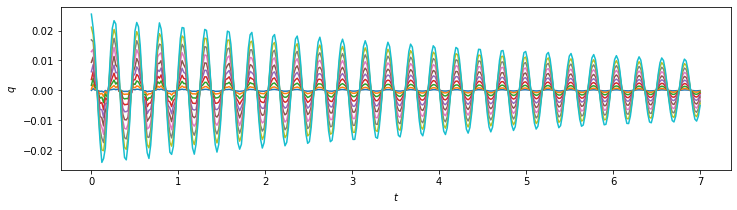

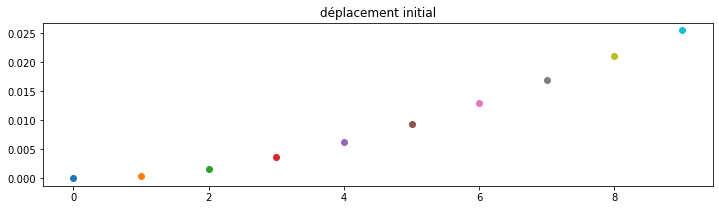

In [14]:
plt.figure();
for i in range(3):
    plt.plot(t,eta[2*i,:],'-');
    print(2*i)
plt.xlabel("$t$");
plt.ylabel("$\eta$");


plt.figure();
for i in range(n_elem):
    plt.plot(t,qf[2*i,:],'-');
plt.xlabel("$t$");
plt.ylabel("$q$");

plt.figure()
plt.title('déplacement initial')
for i in range(n_elem):
    plt.plot(i,qf[2*i,0],'o');
print(np.shape(qf))